In [1]:
import gym
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
env = gym.make("Taxi-v3").env

In [3]:
env.reset() # reset env to a random state
env.render() # blue letter is passenger pick up location & purple letter is destination

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
# 0: going down; 1: going up; 2: going right; 3: going left; 4: picking up; 5: dropping off
# => Action space of 6

print('Action space of size', env.action_space.n)

# state is vector: (row of taxi, col of taxi, passenger index, destination index)
# passenger is either in R,G,Y, B or in taxi => passenger index of 0,1,2,3,4 respectively
# destination is also either R,G,Y or B
# So: 5 rows, 5 cols, 5 passenger indexes and 4 destination indexes
# => State space of 5x5x5x4 (= 500): state vector will be encoded as value between 0 and 499

print('State space of size', env.observation_space.n) 

Action space of size 6
State space of size 500


In [5]:
# Example state
state = env.encode(3, 1, 2, 0) # (taxi row 3, taxi column 2, passenger index 2 (Y), destination index 0 (R))
print("State:", state)

env.s = state # vector encode
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
# reward structure: passenger pick-up/drop-off => +20; illegal pick-up/drop-off => -10; other: -1 
# reward table for state represented as {action: [(probability, nextstate, reward, done)]}

env.P[state]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

## Q learning

In [7]:
# init Q table as 500x6 table of zeroes

# Goal: learn 'real' value of certain action in certain state
# => learn Q value of (action, state) combinations

q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [8]:
# init hyperparameters

alpha = 0.05 # learning rate <-> by how much do we want to update Q values each iteration
gamma = 0.6 # discount factor (future rewards vs. immediate rewards)
epsilon = 0.1 # determines epsilon greediness (exploration vs exploitation): 10% probability of taking random action & 90% of taking current best action

In [10]:
# model training
t1 = time.time()
rewards, epochs, penalties = [], [], []

for episode in range(1, 50001): # train Q table for 50k episodes
    state = env.reset()
    done = False
    rew, ep, pen = 0, 0, 0
    
    while not done:
        if random.uniform(0, 1) < epsilon: # epsilon probability
            action = env.action_space.sample() # Exploration: take random action
        else: # (1 - epsilon probability)
            action = np.argmax(q_table[state]) # Exploitation: take best action for current state according to current Q table

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            pen += 1
        rew += reward
        ep += 1
        
        state = next_state
    
    rewards.append(rew)
    epochs.append(ep)
    penalties.append(pen)

print(f'training finished: {time.time() - t1} seconds')

training finished: 60.46092128753662 seconds


## Training metrics Visualization

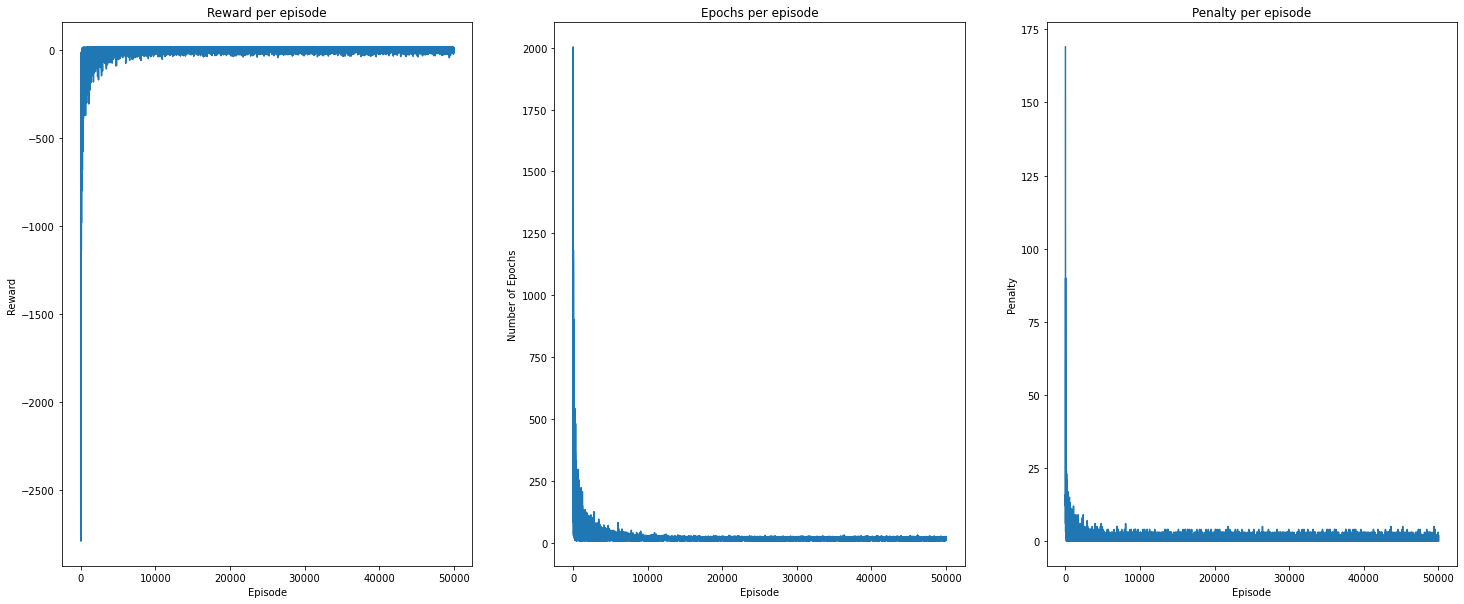

In [11]:
fig = plt.figure(figsize = (25,10))

plt.subplot(1, 3, 1)
plt.title('Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(range(len(rewards)), rewards)

plt.subplot(1, 3, 2)
plt.title('Epochs per episode')
plt.xlabel('Episode')
plt.ylabel('Number of Epochs')
plt.plot(range(len(epochs)), epochs)

plt.subplot(1, 3, 3)
plt.title('Penalty per episode')
plt.xlabel('Episode')
plt.ylabel('Penalty')
plt.plot(range(len(penalties)), penalties)

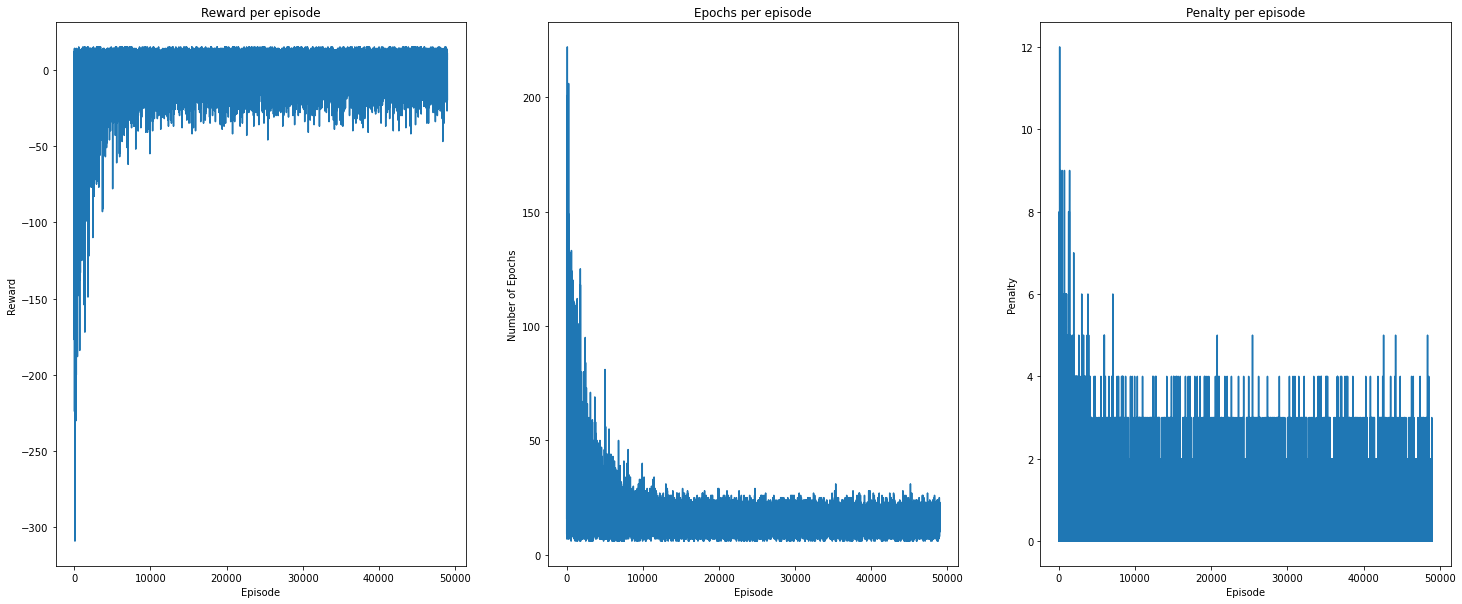

In [16]:
# same visual but without initial outlier

fig = plt.figure(figsize = (25,10))

plt.subplot(1, 3, 1)
plt.title('Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(range(len(rewards) - 1000), rewards[1000:])

plt.subplot(1, 3, 2)
plt.title('Epochs per episode')
plt.xlabel('Episode')
plt.ylabel('Number of Epochs')
plt.plot(range(len(epochs) - 1000), epochs[1000:])

plt.subplot(1, 3, 3)
plt.title('Penalty per episode')
plt.xlabel('Episode')
plt.ylabel('Penalty')
plt.plot(range(len(penalties) - 1000), penalties[1000:])

Looks like there is no real improvement in performance after 10 000 - 15 000 episodes of training

## Visualization of best actions on random state

In [17]:
def print_frame(frame):
    clear_output(wait=True)
    print(frame['frame'])
    print(f"Timestep: {epochs + 1}")
    print(f"State: {frame['state']}")
    print(f"Action: {frame['action']}")
    print(f"Reward: {frame['reward']}")
    time.sleep(.1)

In [18]:
state = env.reset()
env.s = state

epochs = 0
penalties, reward = 0, 0

frames = []

done = False

while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
        
    print_frame({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        })

    epochs += 1

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 12
State: 85
Action: 5
Reward: 20


## More formal test of performance

In [19]:
#track metrics of Q learned agent over many episodes

total_epochs, total_penalties, stuck, total_reward = 0, 0, 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1
            
        total_reward += reward
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

resultsQ = {'epochs': total_epochs, 'penalties': total_penalties, 'reward': total_reward}
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Average reward per episode: {total_reward / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.23
Average penalties per episode: 0.0
Average reward per episode: 7.77


In [20]:
# track metrics of random agent as baseline

total_epochs, total_penalties, total_reward = 0, 0, 0

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        t = time.time()
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        total_reward += reward
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

resultsRandom = {'epochs': total_epochs, 'penalties': total_penalties, 'reward': total_reward}
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Average reward per episode: {total_reward / episodes}")

Results after 100 episodes:
Average timesteps per episode: 2378.54
Average penalties per episode: 770.66
Average reward per episode: -9293.48


In [21]:
# Q learned agent vs Random agent
print('-------------------------------------')
print("\tPerformance Summary")
print('-------------------------------------')
print()
print('Q learned Agent:')
print('-------------------------------------')
print(f"Average timesteps per episode: {resultsQ['epochs'] / episodes}")
print(f"Average penalties per episode: {resultsQ['penalties'] / episodes}")
print(f"Average reward per episode: {resultsQ['reward'] / episodes}")
print()
print('Random Agent:')
print('-------------------------------------')
print(f"Average timesteps per episode: {resultsRandom['epochs'] / episodes}")
print(f"Average penalties per episode: {resultsRandom['penalties'] / episodes}")
print(f"Average reward per episode: {resultsRandom['reward'] / episodes}")

-------------------------------------
	Performance Summary
-------------------------------------

Q learned Agent:
-------------------------------------
Average timesteps per episode: 13.23
Average penalties per episode: 0.0
Average reward per episode: 7.77

Random Agent:
-------------------------------------
Average timesteps per episode: 2378.54
Average penalties per episode: 770.66
Average reward per episode: -9293.48


It is clear that the Q learned agent significantly outperforms the random agent